In [1]:
from slp.config.load_config import load_segmentation_task_config
from slp.config.loading.data import load_segmentation_dataset
from slp.config.loading.trainer import load_segmentation_lightning_module
from slp.codecs.segmentation.per_frame_labels import PerFrameLabelsCodec
from slp.codecs.segmentation.offsets import OffsetsCodec

import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
config_per_frames = load_segmentation_task_config("../configs/inference_per_frames.yaml")
config_offsets = load_segmentation_task_config("../configs/inference_offsets.yaml")
dataset, _ = load_segmentation_dataset(config_per_frames.datasets['testing'])
module_per_frames = load_segmentation_lightning_module(config_per_frames)
module_offsets = load_segmentation_lightning_module(config_offsets)
per_frame_codec = PerFrameLabelsCodec()
offsets_codec = OffsetsCodec(per_frame_codec)

Loading instances from shards: file:D:/data/sign-languages/lsfb-cont/shards/shard_000004.tar
Loading checkpoint: D:/data/sign-languages/outs/slp_old/segmentation/slp/checkpoints/lsfb_actionness_1746993295798/epoch=53-step=8262.ckpt
Loading checkpoint: D:/data/sign-languages/outs/slp_old/segmentation/slp/checkpoints/lsfb_actionness_with_offsets_1746993295800/epoch=112-step=17289.ckpt


In [3]:
def get_predicted_segments(sample, model, codec, device='cuda'):
    model = model.to(device)
    x = torch.from_numpy(sample['poses']).float().unsqueeze(0).to(device)
    mask = torch.ones(1, x.shape[0]).to(device)
    with torch.inference_mode():
        logits = model(x, mask)[-1, 0]
    segments = codec.decode_logits_to_segments(logits, n_classes=2)
    return segments.detach().cpu().numpy(), logits[:, :2].softmax(dim=-1)

In [4]:
def plot_segments(segments: np.ndarray, y_lim=(0, 0.5), x_lim=None, ax=None, alpha=0.5, **kwargs):
    if ax is None:
        ax = plt.gca()
    y_min, y_max = y_lim
    if x_lim is None:
        x_lim = (segments.min() - 100, segments.max() + 100)
    x_min, x_max = x_lim
    plt.hlines(y_min, xmin=x_min, xmax=x_max, color='black', linestyles='solid')
    for index, segment in enumerate(segments):
        start, end = segment[:2]
        ax.axvspan(start, end+1, ymin=y_min, ymax=y_max, alpha=alpha, edgecolor='black', linewidth=0.5, **kwargs)

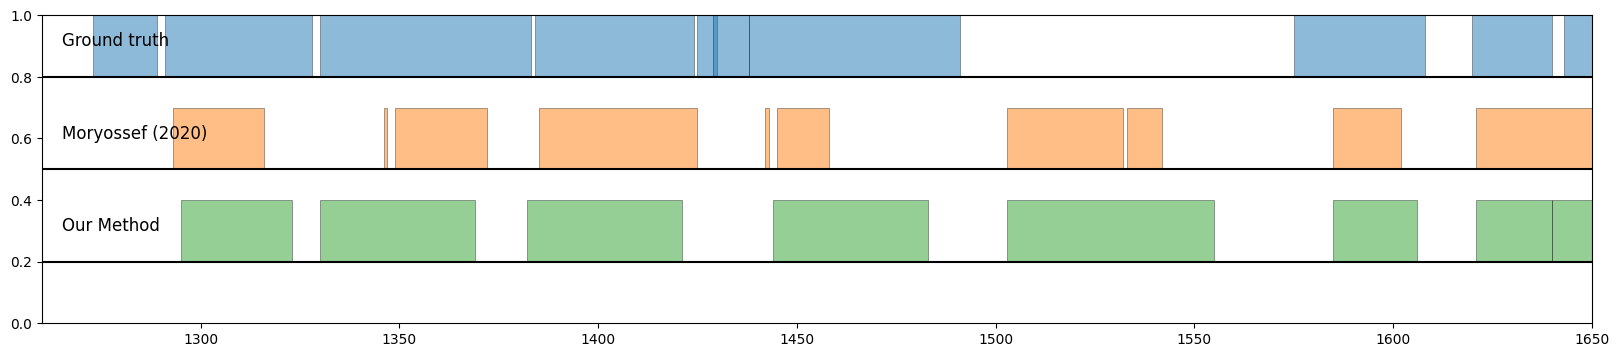

In [10]:
sample = dataset[40]
gt_segments = sample['segments']
pred_segments_per_frames, probs_offsets = get_predicted_segments(sample, model=module_per_frames.backbone, codec=per_frame_codec)
pred_segments_offsets, scores = get_predicted_segments(sample, model=module_offsets.backbone, codec=offsets_codec)

colors = plt.cm.tab10(np.linspace(0, 1, 10))
plt.figure(figsize=(20, 4))
x_min, x_max = 1260, 1650
plt.xlim(x_min, x_max)
plt.ylim(0, 1)
# plt.axis('off')
plot_segments(gt_segments, y_lim=(0.8, 1.0), facecolor=colors[0])
plot_segments(pred_segments_per_frames, y_lim=(0.5, 0.7), facecolor=colors[1])
plot_segments(pred_segments_offsets, y_lim=(0.2, 0.4), facecolor=colors[2])
plt.annotate('Ground truth', (x_min + 5, 0.9), fontsize=12)
plt.annotate('Moryossef (2020)', (x_min + 5, 0.6), fontsize=12)
plt.annotate('Our Method', (x_min + 5, 0.3), fontsize=12)
plt.show()